In [1]:
# fnames_behavioral = ['../data/behavioral/2019_08_12/random_corrective_saccades_160452.fhd', '../data/behavioral/2019_08_12/random_corrective_saccades_153356.fhd']
# fnames_cs_indices = ['../data/OpenEphys_data/2019-08-12/2019-08-12_16-04-50/channel_1.CS.csv', '../data/OpenEphys_data/2019-08-12/2019-08-12_15-33-54/channel_1.CS.csv']

In [1]:
sess_indices = [4,5,48,49,56,58,59,60,61,64,66,69,70,74]


In [2]:
from fhd import *
import OpenEphys
import matplotlib.pyplot as plt
import numpy as np
from kaveh.toolbox import find_files_regex
import pandas as pd
import time
t0 = time.time()
import OpenEphys
from kaveh.toolbox import common_avg_ref, butter_bandpass_filter
import Kwik
from matplotlib import pyplot as plt
import numpy as np
import os
import re
import scipy.signal

In [3]:
import numpy as np
import csv

In [4]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [5]:
experiments_csv = '../data/tetrode-heptode-ephys_recording_notes - Sheet1.csv'

df = pd.read_csv(experiments_csv)
exp_info = df[['date','OE', 'EL', 'CH']].dropna()

sessions_info = []
behavioral_source_dir = '../data/behavioral/'
OE_source_dir = '../data/OpenEphys_data/'
fnames = []
for idx, (_, row) in enumerate(exp_info.iterrows()):
    print(idx)
    recording_date = row['date']
    sess_EL = row['EL']
    sess_OE = row['OE']
    chan = row['CH']
    OE_source = os.path.join(OE_source_dir, recording_date, recording_date + '_' + sess_OE)
    behavioral_file  = find_files_regex(os.path.join(behavioral_source_dir, recording_date.replace('-','_')), r".*{}\.fhd$".format(sess_EL.replace('-','')))
    curr_sess = (chan,)
    if len(behavioral_file) == 1:
        print(behavioral_file[0])
        curr_sess = (behavioral_file[0],) + curr_sess
    elif len(behavioral_file) > 1:
        raise ValueError('multiple behavioral files found for the same timestamp: {}'.format(behavioral_file))
    else:
        print('Behavioral file not found: {}'.format(sess_EL))
    if os.path.exists(OE_source):
        print(OE_source)
        curr_sess = (OE_source,) + curr_sess
    else:
        print('Open Ephys directory not found: {}'.format(OE_source))
    sessions_info = sessions_info + [curr_sess]
    print('-------------------')

0
../data/behavioral/2019_08_12/random_corrective_saccades_140142.fhd
../data/OpenEphys_data/2019-08-12/2019-08-12_14-01-39
-------------------
1
../data/behavioral/2019_08_12/random_corrective_saccades_142257.fhd
../data/OpenEphys_data/2019-08-12/2019-08-12_14-22-55
-------------------
2
../data/behavioral/2019_08_12/random_corrective_saccades_144317.fhd
../data/OpenEphys_data/2019-08-12/2019-08-12_14-43-14
-------------------
3
../data/behavioral/2019_08_12/random_corrective_saccades_150416.fhd
../data/OpenEphys_data/2019-08-12/2019-08-12_15-04-14
-------------------
4
../data/behavioral/2019_08_12/random_corrective_saccades_153356.fhd
../data/OpenEphys_data/2019-08-12/2019-08-12_15-33-54
-------------------
5
../data/behavioral/2019_08_12/random_corrective_saccades_160452.fhd
../data/OpenEphys_data/2019-08-12/2019-08-12_16-04-50
-------------------
6
../data/behavioral/2019_08_12/random_corrective_saccades_163652.fhd
../data/OpenEphys_data/2019-08-12/2019-08-12_16-36-49
------------

In [6]:
sessions_analyzed = [sessions_info[i] for i in sess_indices]

In [7]:
fnames_behavioral = [sa[1] for sa in sessions_analyzed]

In [8]:
fnames_cs_indices = [os.path.join(sa[0], 'channel_{}.CS.csv'.format(sa[2]-1)) for sa in sessions_analyzed]

In [9]:
fnames_cs_indices

['../data/OpenEphys_data/2019-08-12/2019-08-12_15-33-54/channel_1.CS.csv',
 '../data/OpenEphys_data/2019-08-12/2019-08-12_16-04-50/channel_1.CS.csv',
 '../data/OpenEphys_data/2019-04-12/2019-04-12_12-07-02/channel_4.CS.csv',
 '../data/OpenEphys_data/2019-04-12/2019-04-12_12-20-25/channel_4.CS.csv',
 '../data/OpenEphys_data/2019-04-15/2019-04-15_15-38-18/channel_0.CS.csv',
 '../data/OpenEphys_data/2019-04-24/2019-04-24_16-04-07/channel_4.CS.csv',
 '../data/OpenEphys_data/2019-04-24/2019-04-24_15-33-57/channel_4.CS.csv',
 '../data/OpenEphys_data/2019-04-26/2019-04-26_13-19-12/channel_0.CS.csv',
 '../data/OpenEphys_data/2019-05-01/2019-05-01_14-16-16/channel_2.CS.csv',
 '../data/OpenEphys_data/2019-05-15/2019-05-15_13-52-33/channel_3.CS.csv',
 '../data/OpenEphys_data/2019-05-16/2019-05-16_14-49-04/channel_1.CS.csv',
 '../data/OpenEphys_data/2019-07-24/2019-07-24_14-10-24/channel_3.CS.csv',
 '../data/OpenEphys_data/2019-07-24/2019-07-24_14-29-39/channel_4.CS.csv',
 '../data/OpenEphys_data/

In [10]:
def calc_saccade_reaction_time_to_target_offset(session, target_offset_indices_to_include):
    """
    Function for finding reaction times to targets
    """
    saccade_rt = []
    saccade_rt_target_offset_times = []
    saccade_rt_target_offset_indices = []
    
    for toff, i in zip(session.target_offset_times[target_offset_indices_to_include], target_offset_indices_to_include):
    
        delay_to_next_saccade = session.saccade_onset_times[np.argmax(session.saccade_onset_times > toff)] - toff
        delay_to_next_target_jump = session.target_onset_times[np.argmax(session.target_onset_times > toff)] - toff
        # Only consider reaction times that are less than 600ms and are occurring before the next target jump
        if delay_to_next_saccade <= delay_to_next_target_jump + 0.025 and delay_to_next_saccade <= 0.6 and delay_to_next_saccade>=0:
            saccade_rt.append(delay_to_next_saccade)
            saccade_rt_target_offset_times.append(toff)
            saccade_rt_target_offset_indices.append(i)

    saccade_rt = np.squeeze(np.array(saccade_rt))  # reaction times
    saccade_rt_target_offset_times = np.squeeze(np.array(saccade_rt_target_offset_times)) # target offset times for which the reaction times were calculated
    saccade_rt_target_offset_indices = np.squeeze(np.array(saccade_rt_target_offset_indices)) # indices of target offset times for which the reaction times were calculated
    
    return (saccade_rt, saccade_rt_target_offset_times, saccade_rt_target_offset_indices)


def get_bin_cs_counts(cs_range, event_times, bin_ind, error_dir_bin_numbers, cs_times):
    '''
    get cs_counts for each bin
    '''
#     cs_range = pq.quantity.Quantity(cs_range, 's')
    bin_cs_counts = []
    bin_cs_prob = []
    bin_size = []
    for ebn in error_dir_bin_numbers:
        bin_times = event_times[bin_ind == ebn]
        cs_count = 0
        if bin_times.size != 0:
            for bt in bin_times:
                cs_count = cs_count + np.count_nonzero(np.where(np.logical_and(cs_times < bt+cs_range, cs_times > bt )))
            cs_prob = cs_count*1.0/bin_times.size
            bin_cs_prob.append(cs_prob)
            bin_cs_counts.append(cs_count)
            bin_size.append(bin_times.size)
        else:
            bin_cs_counts.append(0)
            bin_cs_prob.append(0)
            bin_size.append(0)
        
    bin_cs_counts = np.array(bin_cs_counts)
    bin_cs_prob = np.array(bin_cs_prob)
    bin_size = np.array(bin_size)
#     bin_cs_counts = bin_cs_counts*1.0/np.sum(bin_cs_counts)
    return (bin_cs_counts, bin_cs_prob, bin_size)


def bin_error_dirs(error_dirs):
    '''
    Bin error directions: Bins start from 157.5 and increaments counter-clockwise every 45 degrees => 8 bins, 0 to 7
    '''
    bins = np.arange(-180 + 22.5, 180, 45)
    bin_ind = np.digitize(error_dirs , bins, right=True)
    bin_ind[bin_ind == 8] = 0
    return bin_ind


In [30]:
from scipy.io import loadmat
# saving mysess
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle

    
rt_for_file = {}
rt_toffs_for_file = {}
rt_toff_indices_for_file = {}

rt_cs_on_for_file = {}
rt_cs_on_toffs_for_file = {}
rt_cs_on_toff_indices_for_file = {}

rt_cs_off_for_file = {}
rt_cs_off_toffs_for_file = {}
rt_cs_off_toff_indices_for_file = {}


cs_counts_for_file = {}
cs_probs_for_file = {}
bin_sizes_for_file = {}

cs_cs_on_counts_for_file = {}
cs_cs_on_probs_for_file = {}
bin_cs_on_sizes_for_file = {}

cs_cs_off_counts_for_file = {}
cs_cs_off_probs_for_file = {}
bin_cs_off_sizes_for_file = {}

rt_mean_for_file = {}
rt_std_for_file = {}

rt_cs_on_mean_for_file = {}
rt_cs_on_std_for_file = {}

rt_cs_off_mean_for_file = {}
rt_cs_off_std_for_file = {}

bin_cs_counts_for_file = {}
cs_on_ids_for_file = {}
cs_off_ids_for_file = {}

for i,fn in enumerate(fnames_behavioral):
    print(fn)
    input_fn_mat = fn + '.session.mat'
    input_fn_session = fn + '.session.pkl'
#     data = loadmat(input_fn_mat)
    with open(input_fn_session, 'rb') as input:
        try:
            mysess = pickle.load(input, encoding='latin1')
        except TypeError:
            mysess = pickle.load(input)
    
    iss_range = 0.025
    iss_targets = []
    iss_saccades = []
    saccades_with_no_iss_target = []

    for j, (son, soff) in enumerate(zip(mysess.saccade_onset_times, mysess.saccade_offset_times)):
    #     iss_targets.append(np.where(np.logical_or(np.logical_and(mysess.target_onset_times < son + iss_range, 
    #                                                              mysess.target_onset_times > son - iss_range), 
    #                                               np.logical_and(mysess.target_offset_times < soff + iss_range, 
    #                                                              mysess.target_offset_times > soff - iss_range)))[0])
        iss_targets.append(np.where(np.logical_and(mysess.target_onset_times > son - iss_range , mysess.target_offset_times < soff + iss_range))[0])
        if iss_targets[-1].size != 0:
            iss_saccades.append(j)
        if iss_targets[-1].size == 0:
            saccades_with_no_iss_target.append(j)

    iss_targets = np.squeeze(np.array([isst[0] for isst in iss_targets if isst.size != 0]))

    non_iss_target_jumps = np.setdiff1d(np.arange(mysess.target_onset_times.size), iss_targets)

    # iss_targets_successful_trials = iss_targets
    # Only primary target jumps with successful following primary saccade leading to successful trial
    # Only primary target jumps with a following saccade (doesn't have to be a successful saccade/trial)
    non_iss_target_jumps_with_following_iss_tj = np.array([nist for nist in non_iss_target_jumps if np.where(np.logical_and(mysess.target_onset_times[iss_targets] > mysess.target_offset_times[nist] ,
                                                                                                    mysess.target_onset_times[iss_targets] < mysess.target_offset_times[nist] + 0.600) )[0].size !=0])
    
    
    (rt, rt_toffs, rt_toff_indices) = calc_saccade_reaction_time_to_target_offset(mysess, np.squeeze(non_iss_target_jumps_with_following_iss_tj))
    with open(fnames_cs_indices[i], 'r') as csv_f:
        reader = csv.reader(csv_f)
        cs_indices = np.squeeze(np.array(list(reader), dtype=np.int64))
    
    rt_for_file[fn] = rt
    rt_toffs_for_file[fn] = rt_toffs
    rt_toff_indices_for_file[fn] = rt_toff_indices
    # [25, 40, 60, 75, 90]]
    bin_edges = [np.percentile(rt,q) for q in [25, 40, 60, 75, 90]]
    bin_ind_sac_delays = np.digitize(rt, bins = bin_edges)    
    rt_mean_for_file[fn] = [np.mean(rt[bin_ind_sac_delays == i]) for i in range(len(bin_edges)+1)]
    rt_std_for_file[fn] = [np.std(rt[bin_ind_sac_delays == i]) for i in range(len(bin_edges)+1)]
    (cs_counts, cs_probs, bin_sizes) = get_bin_cs_counts(0.200, rt_toffs, bin_ind_sac_delays, np.unique(bin_ind_sac_delays), cs_indices/30000.0)
    cs_counts_for_file[fn] = cs_counts
    cs_probs_for_file[fn] = cs_probs
    bin_sizes_for_file[fn] = bin_sizes

    
    ##########################333

    
    mysess._calc_error_vectors()

    error_dir_bin_ind = mysess.bin_error_dirs()
    error_mag_bin_ind = mysess.bin_error_mags()

    iss_saccades = np.array(iss_saccades)

    iss_saccades_bin_ind = bin_error_dirs(mysess.error_dir[iss_saccades])
    non_iss_saccades_bin_ind = bin_error_dirs(mysess.error_dir[saccades_with_no_iss_target])

    error_dir_bin_numbers = np.unique(error_dir_bin_ind)
    error_mag_bin_numbers = np.unique(error_mag_bin_ind)
    ################## for target jumps
#     ton_VT = np.squeeze(mysess.VT[mysess.target_onsets[non_iss_target_jumps]])
#     toff_VT = np.squeeze(mysess.VT[mysess.target_offsets[non_iss_target_jumps]])

#     ton_HT = np.squeeze(mysess.HT[mysess.target_onsets[non_iss_target_jumps]])
#     toff_HT = np.squeeze(mysess.HT[mysess.target_offsets[non_iss_target_jumps]])

    ton_VT = np.squeeze(mysess.VT[mysess.target_onsets[iss_targets]])
    toff_VT = np.squeeze(mysess.VT[mysess.target_offsets[iss_targets]])

    ton_HT = np.squeeze(mysess.HT[mysess.target_onsets[iss_targets]])
    toff_HT = np.squeeze(mysess.HT[mysess.target_offsets[iss_targets]])


    target_jump_H = toff_HT - ton_HT
    target_jump_V = toff_VT - ton_VT

    target_jump_dir = np.arctan2(target_jump_V, target_jump_H) * 180 / np.pi

    target_jump_mag = np.linalg.norm(np.vstack((target_jump_H, target_jump_V)), axis = 0)

    non_iss_target_jump_bin_ind = np.digitize(target_jump_dir, bins = np.arange(-180 + 22.5, 180, 45))

    non_iss_target_jump_bin_ind[non_iss_target_jump_bin_ind == 8] = 0

#     iss_targets_for_file[ff] = get_bin_cs_counts(0.160, mysess.target_offset_times[non_iss_target_jumps],
#                                                 bin_ind, np.unique(bin_ind), cs_times_gmm)

    
    bin_cs_counts_for_file[fn] = get_bin_cs_counts(0.200, mysess.saccade_offset_times, error_dir_bin_ind, error_dir_bin_numbers, cs_indices/30000.0)[1]
#     print(circular_index2(np.argmax(bin_cs_counts_for_file[fn]), 7))
    
    cs_on_index = np.argmax(bin_cs_counts_for_file[fn])
    cs_off_index = (cs_on_index + 4)%8
    
    cs_on_ids_for_file[fn] = circular_index2(cs_on_index, 7)
    cs_off_ids_for_file[fn] = circular_index2(cs_off_index, 7)
    
#     cs_on_ids_for_file[fn] = [cs_on_index]
#     cs_off_ids_for_file[fn] = [cs_off_index]
#     cs_off_ids_for_file[fn] = circular_index2(np.argmin(bin_cs_counts_for_file[fn]), 7)
#     cs_on_ids_for_file[fn] = circular_index2(np.argmax(bin_cs_counts_for_file[fn]), 7)
#     cs_on_ids_for_file[fn] = [np.argmax(bin_cs_counts_for_file[fn])]
#     cs_off_ids_for_file[fn] = [np.argmin(bin_cs_counts_for_file[fn])]
    ##################################33
    
    cs_on_target_jump_indices = np.where(np.isin(non_iss_target_jump_bin_ind, cs_on_ids_for_file[fn]))
    cs_off_target_jump_indices = np.where(np.isin(non_iss_target_jump_bin_ind, cs_off_ids_for_file[fn]))
    
    (rt_cs_on, rt_toffs_cs_on, rt_toff_indices_cs_on) = calc_saccade_reaction_time_to_target_offset(mysess, np.squeeze(iss_targets[cs_on_target_jump_indices]))
    (rt_cs_off, rt_toffs_cs_off, rt_toff_indices_cs_off) = calc_saccade_reaction_time_to_target_offset(mysess, np.squeeze(iss_targets[cs_off_target_jump_indices]))
    
    rt_cs_on_for_file[fn] = rt_cs_on
    rt_cs_on_toffs_for_file[fn] = rt_toffs_cs_on
    rt_cs_on_toff_indices_for_file[fn] = rt_toff_indices_cs_on
    # [25, 40, 60, 75, 90]]
    bin_edges = [np.percentile(rt_cs_on,q) for q in [25, 40, 60, 75, 90]]
    bin_ind_sac_delays = np.digitize(rt_cs_on, bins = bin_edges)    
    rt_cs_on_mean_for_file[fn] = [np.mean(rt_cs_on[bin_ind_sac_delays == i]) for i in range(len(bin_edges)+1)]
    rt_cs_on_std_for_file[fn] = [np.std(rt_cs_on[bin_ind_sac_delays == i]) for i in range(len(bin_edges)+1)]
    (cs_counts_cs_on, cs_probs_cs_on, bin_sizes_cs_on) = get_bin_cs_counts(0.200, rt_toffs_cs_on, bin_ind_sac_delays, np.unique(bin_ind_sac_delays), cs_indices/30000.0)
    cs_cs_on_counts_for_file[fn] = cs_counts_cs_on
    cs_cs_on_probs_for_file[fn] = cs_probs_cs_on
    bin_cs_on_sizes_for_file[fn] = bin_sizes_cs_on
    print(rt_cs_on.shape)
    rt_cs_off_for_file[fn] = rt_cs_off
    rt_cs_off_toffs_for_file[fn] = rt_toffs_cs_off
    rt_cs_off_toff_indices_for_file[fn] = rt_toff_indices_cs_off
    # [25, 40, 60, 75, 90]]
    bin_edges = [np.percentile(rt_cs_off,q) for q in [25, 40, 60, 75, 90]]
    bin_ind_sac_delays = np.digitize(rt_cs_off, bins = bin_edges)    
    rt_cs_off_mean_for_file[fn] = [np.mean(rt_cs_off[bin_ind_sac_delays == i]) for i in range(len(bin_edges)+1)]
    rt_cs_off_std_for_file[fn] = [np.std(rt_cs_off[bin_ind_sac_delays == i]) for i in range(len(bin_edges)+1)]
    (cs_counts_cs_off, cs_probs_cs_off, bin_sizes_cs_off) = get_bin_cs_counts(0.200, rt_toffs_cs_off, bin_ind_sac_delays, np.unique(bin_ind_sac_delays), cs_indices/30000.0)
    cs_cs_off_counts_for_file[fn] = cs_counts_cs_off
    cs_cs_off_probs_for_file[fn] = cs_probs_cs_off
    bin_cs_off_sizes_for_file[fn] = bin_sizes_cs_off

#     cs_on_np.where(np.isin(non_iss_target_jump_bin_ind, cs_on_ids_for_file[fn]))
    

../data/behavioral/2019_08_12/random_corrective_saccades_153356.fhd
(78,)
../data/behavioral/2019_08_12/random_corrective_saccades_160452.fhd
(68,)
../data/behavioral/2019_04_12/random_corrective_saccades_120703.fhd
(39,)
../data/behavioral/2019_04_12/random_corrective_saccades_122026.fhd
(64,)
../data/behavioral/2019_04_15/random_corrective_saccades_153820.fhd
(115,)
../data/behavioral/2019_04_24/random_corrective_saccades_160409.fhd
(84,)
../data/behavioral/2019_04_24/random_corrective_saccades_153400.fhd
(142,)
../data/behavioral/2019_04_26/random_corrective_saccades_131916.fhd
(45,)
../data/behavioral/2019_05_01/random_corrective_saccades_141618.fhd
(92,)
../data/behavioral/2019_05_15/random_corrective_saccades_135236.fhd
(57,)
../data/behavioral/2019_05_16/random_corrective_saccades_144904.fhd
(74,)
../data/behavioral/2019_07_24/random_corrective_saccades_141028.fhd
(66,)
../data/behavioral/2019_07_24/random_corrective_saccades_142944.fhd
(90,)
../data/behavioral/2019_04_03/random

In [31]:
def circular_index(ind, max_ind):
    if ind < max_ind and ind > 0:
        return [ind - 1, ind, ind + 1]
    elif ind == 0:
        return [max_ind, ind, ind + 1]
    elif ind == max_ind:
        return [ind - 1, ind , 0]
    else:
        raise ValueError('ind should be 0 <= ind <= max_ind')

        
def circular_index2(ind, max_ind):
    if ind < max_ind and ind > 0:
        return [ind, ind + 1]
    elif ind == 0:
        return [ind, ind+1]
    elif ind == max_ind:
        return [ind,0]
    else:
        raise ValueError('ind should be 0 <= ind <= max_ind')

        
def circular_index3(ind, max_ind):
    if ind < max_ind and ind > 0:
        return [ind - 1, ind]
    elif ind == 0:
        return [max_ind, ind]
    elif ind == max_ind:
        return [ind - 1, ind ]
    else:
        raise ValueError('ind should be 0 <= ind <= max_ind')
        

In [32]:
# fnames_cs_indices[5]

In [33]:
#  with open(fnames_cs_indices[4], 'r') as csv_f:
#         reader = csv.reader(csv_f)
#         cs_indices = np.squeeze(np.array(list(reader), dtype=np.int64))

In [34]:
# cs_indices.shape

In [35]:
# calc. mean of cs probabilities across sessions - within session quartile bin edges
# cs_prob_mat = np.array([s for s in cs_prob_for_file.values()])
cs_prob_on_mat = np.array([s for s in cs_cs_on_probs_for_file.values()])
cs_prob_off_mat = np.array([s for s in cs_cs_off_probs_for_file.values()])

rt_mean_mat = np.array([s for s in rt_mean_for_file.values()])
rt_mean_on_mat = np.array([s for s in rt_cs_on_mean_for_file.values()])
rt_mean_off_mat = np.array([s for s in rt_cs_off_mean_for_file.values()])

cs_prob_on_mean = np.mean(cs_prob_on_mat, axis = 0)
cs_prob_on_se = np.std(cs_prob_on_mat, axis = 0)/np.sqrt(cs_prob_on_mat.shape[0])

cs_prob_off_mean = np.mean(cs_prob_off_mat, axis = 0)
cs_prob_off_se = np.std(cs_prob_off_mat, axis = 0)/np.sqrt(cs_prob_off_mat.shape[0])

In [36]:
rt_mean_on_mean = np.mean(rt_mean_on_mat, axis = 0)
rt_mean_on_se = np.std(rt_mean_on_mat, axis = 0)/np.sqrt(rt_mean_on_mat.shape[0])

rt_mean_off_mean = np.mean(rt_mean_off_mat, axis = 0)
rt_mean_off_se = np.std(rt_mean_off_mat, axis = 0)/np.sqrt(rt_mean_off_mat.shape[0])


<IPython.core.display.Javascript object>


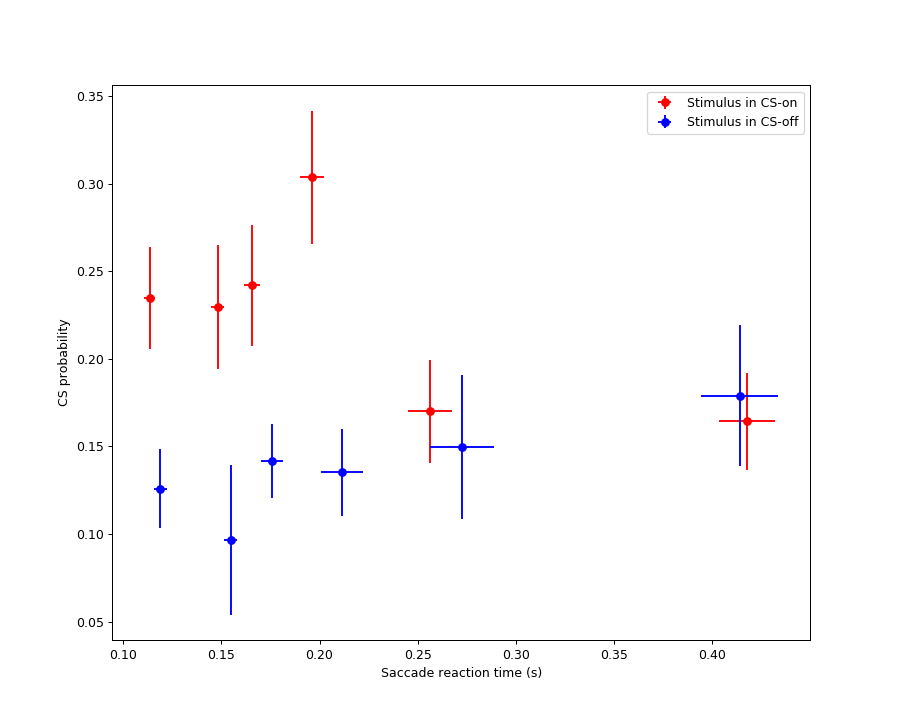

In [37]:
f2 = plt.figure(figsize=(10,8))
plt.errorbar(rt_mean_on_mean, cs_prob_on_mean, yerr=cs_prob_on_se, xerr=rt_mean_on_se, fmt='o', color='r')
plt.errorbar(rt_mean_off_mean, cs_prob_off_mean, yerr=cs_prob_off_se, xerr=rt_mean_off_se, fmt='o', color='b')
# plt.xticks(rt_mean_on_mean)
plt.xlabel('Saccade reaction time (s)')
plt.ylabel('CS probability')
plt.legend(['Stimulus in CS-on', 'Stimulus in CS-off'])
# plt.title('Probability of CS with respect to rxn time for primary saccades (N={})'.format(len(adapt_filenames)))

In [38]:
plt.savefig('../data/plots/Saliency_stuff/marmoset_prob-cs-on-off-rt-error-bars-corrective-saccade-0-200ms_no-grid.png')
plt.savefig('../data/plots/Saliency_stuff/marmoset_prob-cs-on-off-rt-error-bars-corrective-saccade-0-200ms_no-grid.svg')

In [ ]:
Mastercard
5405391682306215
Exp 7/22
CVV2: 104
Reza Shadmehr
410 Traylor
720 Rutland Ave
Baltimore, MD 21205
